In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def Extract_info_from_log(log_file, show = True):
    current_resolution = None
    
    # Regular expressions to match the lines of interest
    res_pattern = re.compile(r'^(360p|720p|2K|4K|8K):$')
    seq_time_pattern = re.compile(r'^Average sequential execution time: ([\d.]+) secs$')
    par_time_pattern = re.compile(r'^Average parallel execution time \((.*?)\): ([\d.e-]+) secs$')
    par_time_load_pattern = re.compile(r'^Average parallel execution time with CUDA load \((.*?)\): ([\d.e-]+) secs$')
    speedup_pattern = re.compile(r'^Speedup \((.*?)\): ([\d.e-]+)$')
    speedup_load_pattern = re.compile(r'^Speedup considering loads \((.*?)\): ([\d.e-]+)$')
    
    for line in log_file:
        # Check for resolution line
        res_match = res_pattern.match(line)
        if res_match:
            current_resolution = res_match.group(1)
            if current_resolution not in data:
                data[current_resolution] = {
                    'Sequential': None,
                    'Global': None,
                    'Tiled': None,
                    'Const': None,
                    'Global_Load': None,
                    'Tiled_Load': None,
                    'Const_Load': None,
                    'Speedup_Global': None,
                    'Speedup_Tiled': None,
                    'Speedup_Const': None,
                    'Speedup_Global_Load': None,
                    'Speedup_Tiled_Load': None,
                    'Speedup_Const_Load': None
                }
            continue
        
        # Check for sequential time
        seq_time_match = seq_time_pattern.match(line)
        if seq_time_match:
            seq_time = float(seq_time_match.group(1))
            data[current_resolution]['Sequential'] = seq_time
            continue
        
        # Check for parallel execution time
        par_time_match = par_time_pattern.match(line)
        if par_time_match:
            kernel = par_time_match.group(1)
            par_time = float(par_time_match.group(2))
            if kernel == 'global':
                data[current_resolution]['Global'] = par_time
            elif kernel == 'tiled':
                data[current_resolution]['Tiled'] = par_time
            elif kernel == 'const':
                data[current_resolution]['Const'] = par_time
            continue
        
        # Check for parallel execution time with CUDA load
        par_time_load_match = par_time_load_pattern.match(line)
        if par_time_load_match:
            kernel = par_time_load_match.group(1)
            par_time_load = float(par_time_load_match.group(2))
            if kernel == 'global':
                data[current_resolution]['Global_Load'] = par_time_load
            elif kernel == 'tiled':
                data[current_resolution]['Tiled_Load'] = par_time_load
            elif kernel == 'const':
                data[current_resolution]['Const_Load'] = par_time_load
            continue
        
        # Check for speedup
        speedup_match = speedup_pattern.match(line)
        if speedup_match:
            kernel = speedup_match.group(1)
            speedup = float(speedup_match.group(2))
            if kernel == 'global':
                data[current_resolution]['Speedup_Global'] = speedup
            elif kernel == 'tiled':
                data[current_resolution]['Speedup_Tiled'] = speedup
            elif kernel == 'const':
                data[current_resolution]['Speedup_Const'] = speedup
            continue
        
        # Check for speedup with loads
        speedup_load_match = speedup_load_pattern.match(line)
        if speedup_load_match:
            kernel = speedup_load_match.group(1)
            speedup_load = float(speedup_load_match.group(2))
            if kernel == 'global':
                data[current_resolution]['Speedup_Global_Load'] = speedup_load
            elif kernel == 'tiled':
                data[current_resolution]['Speedup_Tiled_Load'] = speedup_load
            elif kernel == 'const':
                data[current_resolution]['Speedup_Const_Load'] = speedup_load
            continue
    
    # Debugging: Print the parsed data to check if all fields are populated correctly
    if show:
        for resolution, metrics in data.items():
            print(f"{resolution}:")
            for key, value in metrics.items():
                print(f"  {key}: {value}")
    return data

def add_values(ax, data):
        for container in ax.containers:
            for bar in container:
                height = bar.get_height()
                ax.annotate(f'{height:.1f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', size = 8)

def Visualize_speedup_plot(data, title=""):
    # Convert nested dictionary to DataFrame for easier manipulation
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.reindex(['360p', '720p', '2K', '4K'])
    # Plot the speedup without loads
    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()
    ax1.set_yscale('log')
    df[['Speedup_Global', 'Speedup_Tiled', 'Speedup_Const']].plot(kind='bar', ax=plt.gca())
    plt.title('Speedup without CUDA loads')
    plt.ylabel('Speedup')
    plt.xlabel('Resolution')
    plt.xticks(rotation=0)
    ax1.legend(['Global', 'Tiled', 'Tiled + Const'], title='Kernel Version', loc = 'upper left')
    add_values(ax1, df[['Speedup_Global', 'Speedup_Tiled', 'Speedup_Const']])
    #plt.tight_layout()
    plt.savefig('speedup_without_loads'+title+'.png')
    
    # Plot the speedup with loads
    plt.figure(figsize=(12, 6))
    ax2 = plt.gca()
    ax2.set_yscale('log')
    df[['Speedup_Global_Load', 'Speedup_Tiled_Load', 'Speedup_Const_Load']].plot(kind='bar', ax=plt.gca())
    plt.title('Speedup with CUDA loads')
    plt.ylabel('Speedup')
    plt.xlabel('Resolution')
    plt.xticks(rotation=0)
    ax2.legend(['Global', 'Tiled', 'Tiled + Const'], title='Kernel Version', loc = 'upper left')
    add_values(ax2, df[['Speedup_Global_Load', 'Speedup_Tiled_Load', 'Speedup_Const_Load']])
    #plt.tight_layout()
    plt.savefig('speedup_with_loads'+title+'.png')
    
    plt.show()


**Block (16,16) with 3x3 kernel**

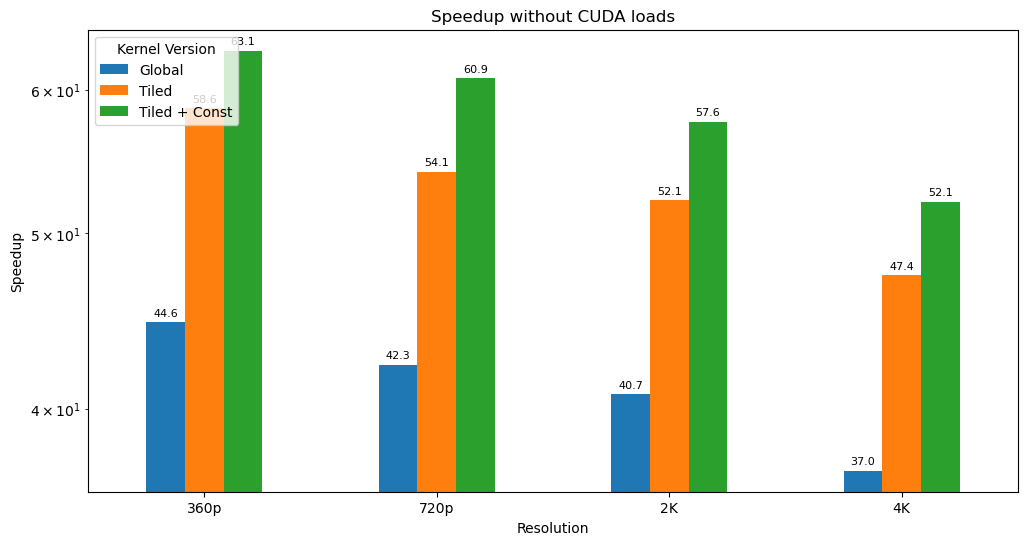

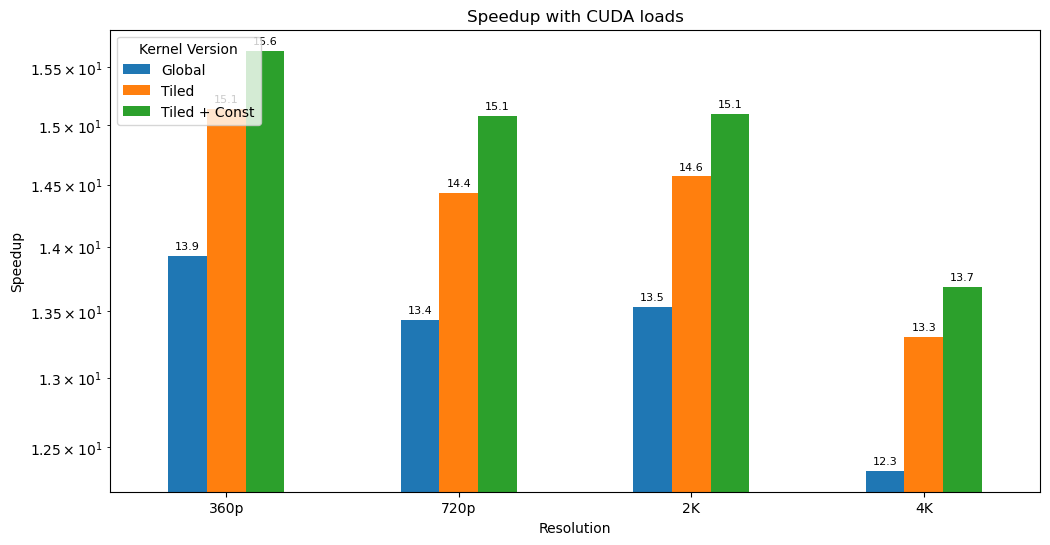

In [3]:
# Initialize dictionary to store data
data = {}

#FILES: Results, Results_32x32_3x3
# Read and parse the text file
with open('Results_16x16_3x3.txt', 'r') as file:
    content = file.readlines()

data = Extract_info_from_log(content, show= False)
Visualize_speedup_plot(data,"16x16_3x3")


**Block (16,16) with 5x5 kernel**

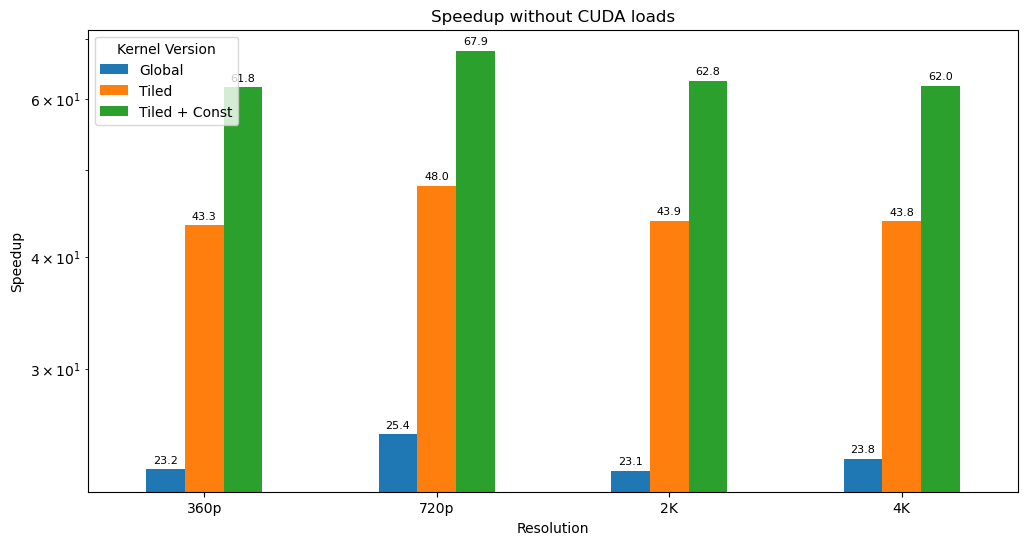

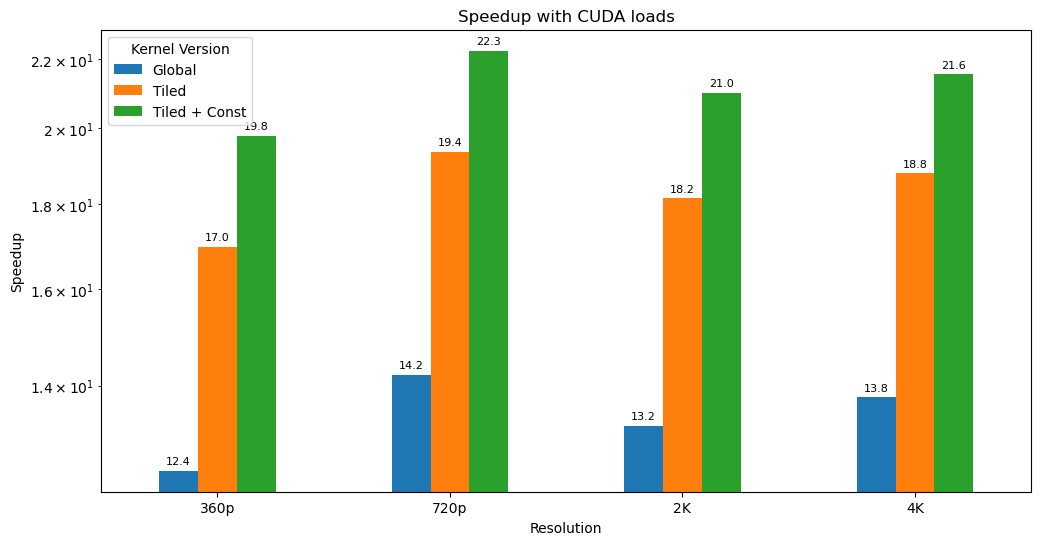

In [4]:
# Initialize dictionary to store data
data = {}

#FILES: Results, Results_32x32_3x3
# Read and parse the text file
with open('Results_16x16_5x5.txt', 'r') as file:
    content = file.readlines()

data = Extract_info_from_log(content, show= False)
Visualize_speedup_plot(data,"16x16_5x5")

**Block (32,32) with 3x3 kernel**

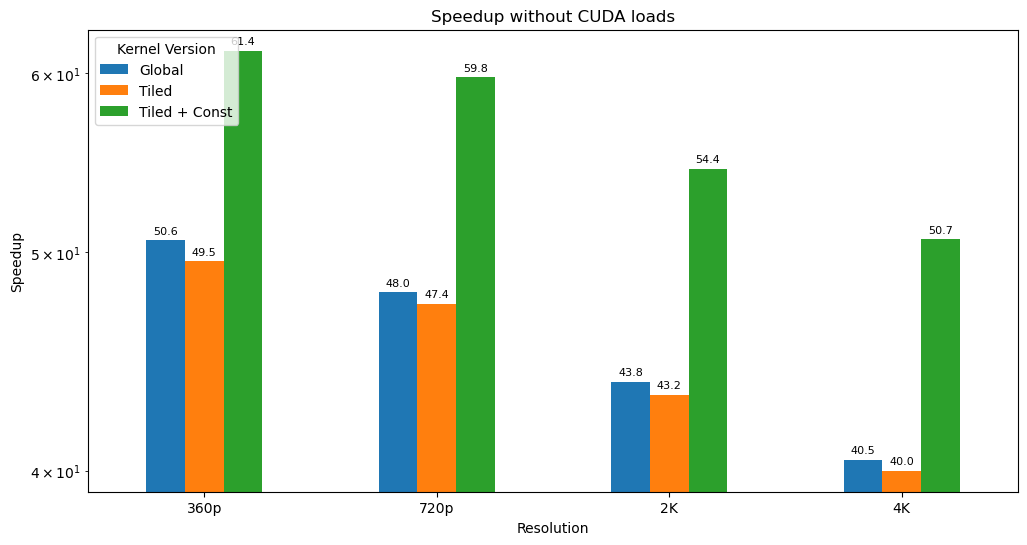

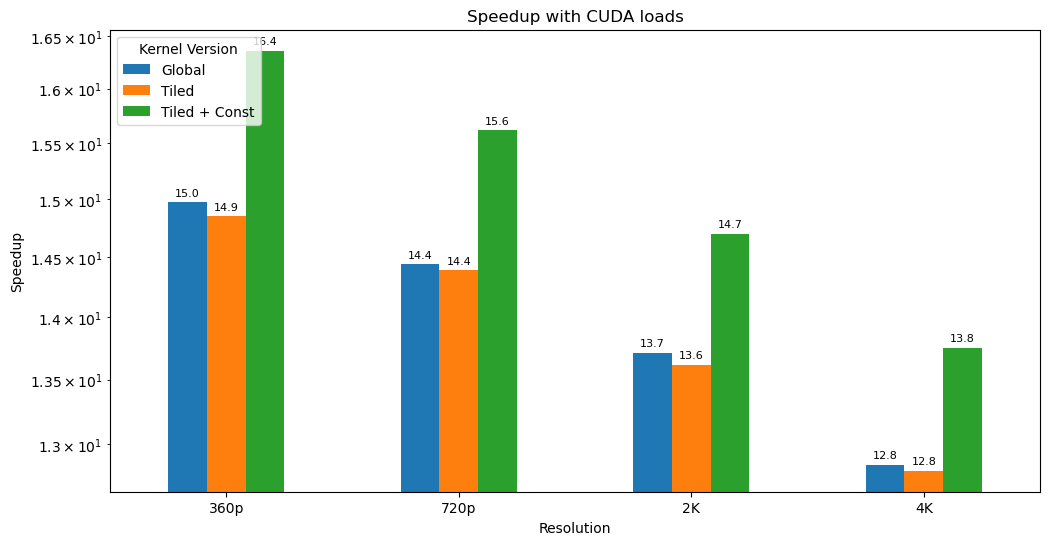

In [5]:
# Initialize dictionary to store data
data = {}

#FILES: Results, Results_32x32_3x3
# Read and parse the text file
with open('Results_32x32_3x3.txt', 'r') as file:
    content = file.readlines()

data = Extract_info_from_log(content, show= False)
Visualize_speedup_plot(data,"32x32_3x3")

**Block (32,32) with 5x5 kernel**

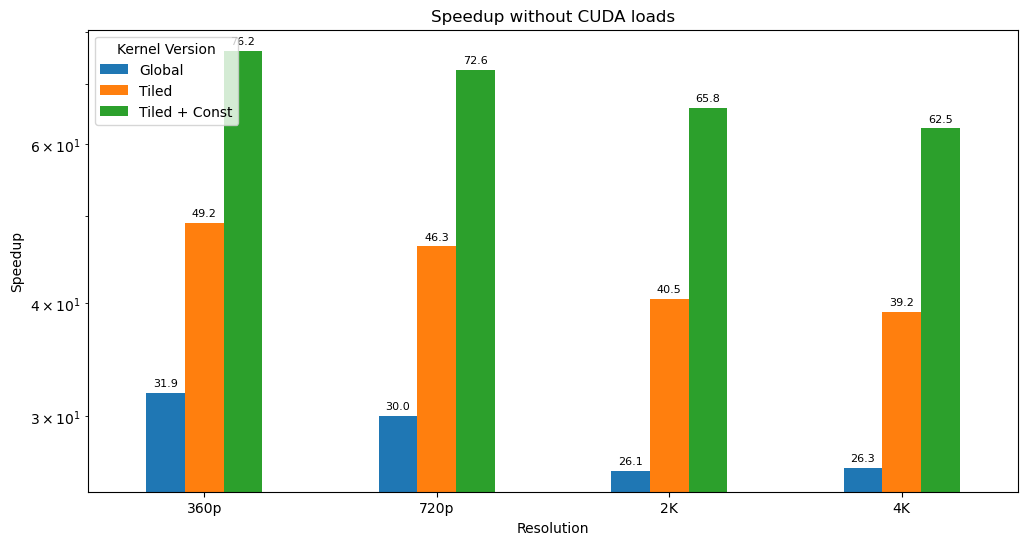

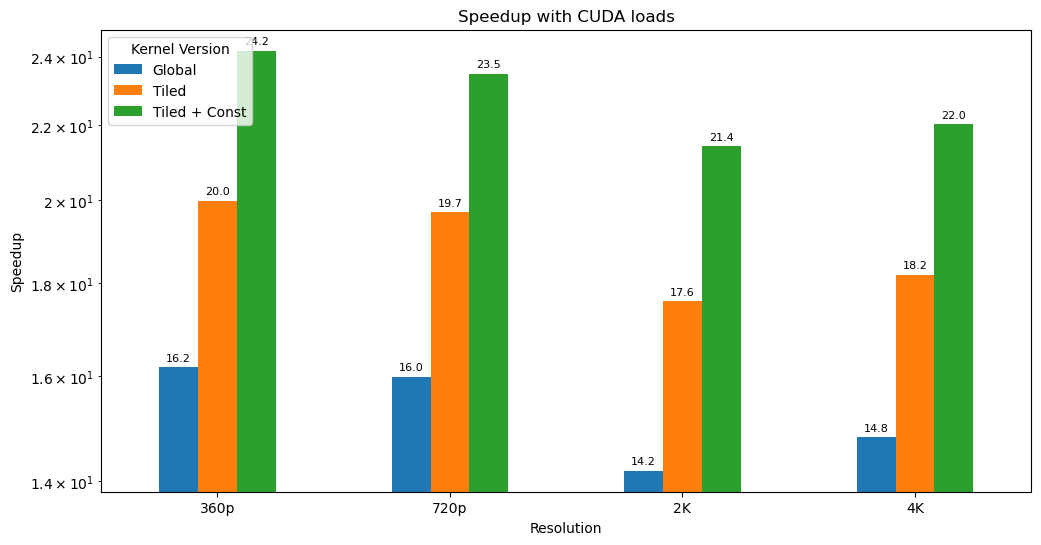

In [6]:
# Initialize dictionary to store data
data = {}

#FILES: Results, Results_32x32_3x3
# Read and parse the text file
with open('Results_32x32_5x5.txt', 'r') as file:
    content = file.readlines()

data = Extract_info_from_log(content, show= False)
Visualize_speedup_plot(data,"32x32_5x5")